# IMDb Rating Prediction

---

### Importação de bibliotecas básicas

In [581]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

### Adiciona raiz do projeto ao PYTHONPATH

In [582]:
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent))

### Import das funções dos scripts específicos

In [583]:
from src.preprocess import basic_clean

### Carregar dataset no pandas

In [584]:
df = pd.read_csv('../data/desafio_indicium_imdb.csv')

## 1. Análise Exploratória dos Dados (EDA)

### Dimensões do dataframe:

In [585]:
df.shape

(999, 16)

### Amostra dos 5 primeiros dados:

In [586]:
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


### Visão geral sobre as colunas, incluindo o tipo, a quantidade de valores não-nulos e uso de memória:

In [587]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


#### Isolando os valores faltantes de cada coluna:

In [588]:
df_isnull = df.isnull().sum().to_frame('Count missing values').reset_index().rename(columns={'index':'Column'})

df_isnull[df_isnull['Count missing values'] > 0]

,Column,Count missing values
3,Certificate,101
8,Meta_score,157
15,Gross,169


### Estatísticas descritivas para cada coluna numérica:

In [589]:
df.describe()

,Unnamed: 0,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,999.000000,842.000000,9.990000e+02
mean,500.000000,7.947948,77.969121,2.716214e+05
std,288.530761,0.272290,12.383257,3.209126e+05
min,1.000000,7.600000,28.000000,2.508800e+04
25%,250.500000,7.700000,70.000000,5.547150e+04
50%,500.000000,7.900000,79.000000,1.383560e+05
75%,749.500000,8.100000,87.000000,3.731675e+05
max,999.000000,9.200000,100.000000,2.303232e+06


### Estatísticas descritivas para colunas não-numéricas:

In [590]:
df.describe(include=['object'])

,Series_Title,Released_Year,Certificate,Runtime,Genre,Overview,Director,Star1,Star2,Star3,Star4,Gross
count,999,999,898,999,999,999,999,999,999,999,999,830
unique,998,100,16,140,202,999,548,659,840,890,938,822
top,Drishyam,2014,U,130 min,Drama,An organized crime dynasty's aging patriarch t...,Alfred Hitchcock,Tom Hanks,Emma Watson,Rupert Grint,Michael Caine,"4,360,000"
freq,2,32,234,23,84,1,14,12,7,5,4,5


### Primeiras observações:

1. O Dataframe possui 999 linhas e 16 colunas em seu formato original – precisamos verificar e remover possíveis duplicatas;
2. A coluna ``"Unnamed: 0"`` é apenas um índice salvo no CSV e não apresenta nenhuma informação útil, portanto vai ser removida;
3. A coluna ``"Released_year"`` é do tipo object, mas deveria ser numérico (int), logo vai ser convertida;
4. ``"Certificate"``, que indica a classificação indicativa, tem 101 valores ausentes. Por se tratar de uma variável categórica e importante para caracterizar o público-alvo, os valores foram imputados como "Unknown", evitando perda de dados e mantendo consistência do modelo.
5. ``"Gross"``, o faturamento bruto, precisa ser convertido para numérico, atualmente está como object.
6. ``"Meta_score"`` tem 157 valores ausentes. Neste caso, como a sua distribuição é estável (média é aproximadamente 78 e a mediana é 79), optou-se por imputar o valor da média. Essa escolha preserva a variável sem introduzir viés relevante na predição.
7. ``"Gross"`` tem 169 valores ausentes – neste caso, a decisão foi remover as linhas correspondentes, já que o faturamento é uma métrica central e imputá-la poderia distorccer análises financeiras.
8. ``"Runtime"`` está como object, mas também pode ser convertida para inteiro.

Assim sendo, o script ``src/preprocess.py`` é o responsável por centralizar as funções de pré-processamento associadas a essas conclusões. Nele, está sendo feito o tratamento completo, desde a remoção de colunas desnecessárias, até imputação ou remoção de linhas faltantes, e conversão de valores em numéricos.

In [591]:
df_cleaned = basic_clean(df)

Conferindo o estado do dataframe pós-limpeza:

In [592]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 829 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Series_Title   829 non-null    object  
 1   Released_Year  829 non-null    float64 
 2   Certificate    829 non-null    category
 3   Runtime        829 non-null    Int64   
 4   Genre          829 non-null    object  
 5   IMDB_Rating    829 non-null    float64 
 6   Overview       829 non-null    object  
 7   Meta_score     829 non-null    float64 
 8   Director       829 non-null    object  
 9   Star1          829 non-null    object  
 10  Star2          829 non-null    object  
 11  Star3          829 non-null    object  
 12  Star4          829 non-null    object  
 13  No_of_Votes    829 non-null    int64   
 14  Gross          829 non-null    float64 
dtypes: Int64(1), category(1), float64(4), int64(1), object(8)
memory usage: 99.4+ KB


Tendo aplicado as limpezas necessárias, vamos partir para a EDA mais profunda no df_cleaned. 

### 1.1. Análise Exploratória dos Dados (EDA) - Pós Limpeza

---

### Gráficos de dispersão com linha de tendência:

#### 1. IMDB_Rating x Gross
**Hipótese 1:** Filmes melhor avaliados tendem a ter maior bilheteria?

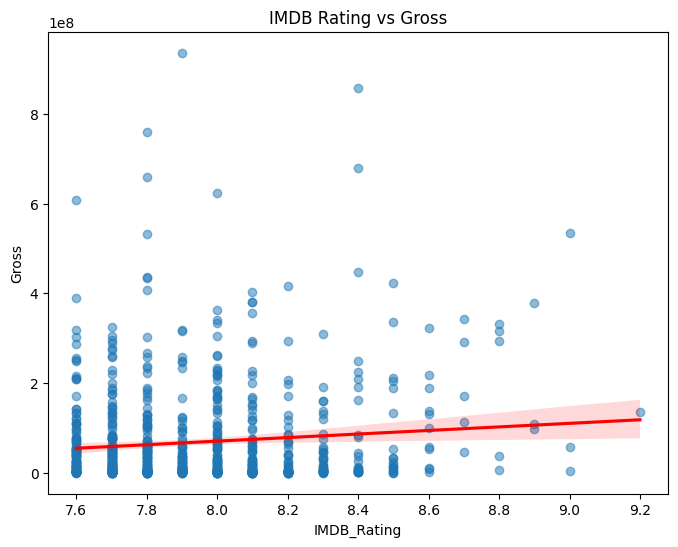

In [593]:
plt.figure(figsize=(8,6))
sns.regplot(x="IMDB_Rating", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("IMDB Rating vs Gross")
plt.show()


- **Tendência positiva fraca**: filmes com maior nota até arrecadam um pouco mais, mas a relação é quase nula;
- Existem vários filmes com notas boas, mas baixo faturamento. Isso significa que uma nota alta não garante sucesso comercial.

---

#### 2. Runtime x Gross
**Hipótese 2:** O tempo de duração do filme influencia no seu faturamento?

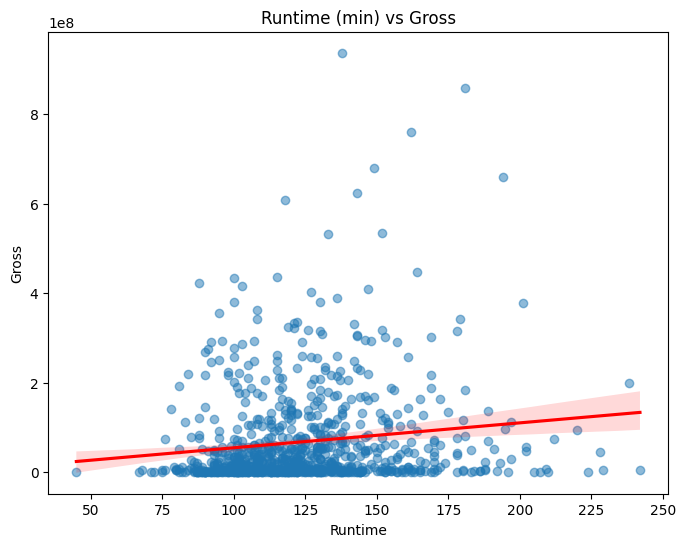

In [594]:
plt.figure(figsize=(8,6))
sns.regplot(x="Runtime", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Runtime (min) vs Gross")
plt.show()


- Existe uma **correlação positiva fraca**, o que pode indicar que filmes longos tendem a arrecadar mais. 
- Porém, é preciso considerar que a dispersão é enorme, o que significa que essa relação não é consistente e muitos filmes longos não obtêm uma grande bilheteria.
- O que pode estar acontecendo: Blockbusters, que geralmente tem maior duração, acabam puxando a tendência para cima.

---

#### 3. No_of_votes x Gross
**Hipótese 3:** O número de votos pode estar associado à maior popularidade, mas isso significa maior arrecadação?

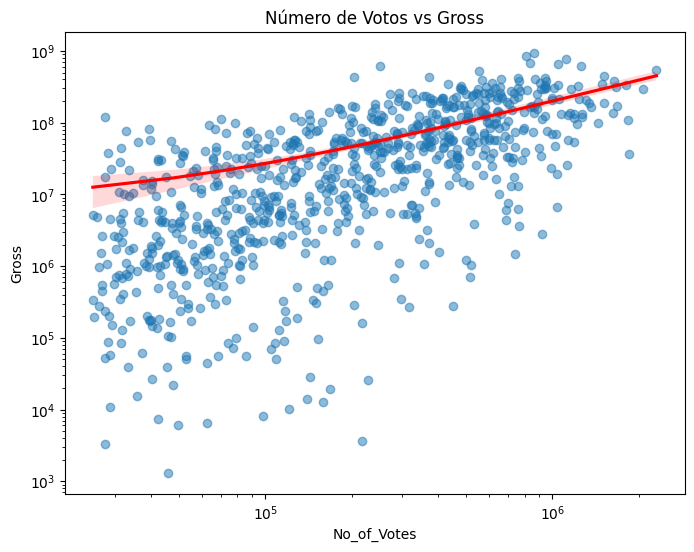

In [595]:
plt.figure(figsize=(8,6))
sns.regplot(x="No_of_Votes", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Número de Votos vs Gross")
plt.xscale("log")
plt.yscale("log")
plt.show()


- **Forte correlação positiva**, quase linear em escala log.
- Isso significa que mais votos refletem maior popularidade, e filmes populares arrecadam mais.

---

#### 4. IMDB_Rating x No_of_votes
**Hipótese 4:** Filmes mais votados costumam ter notas maiores?

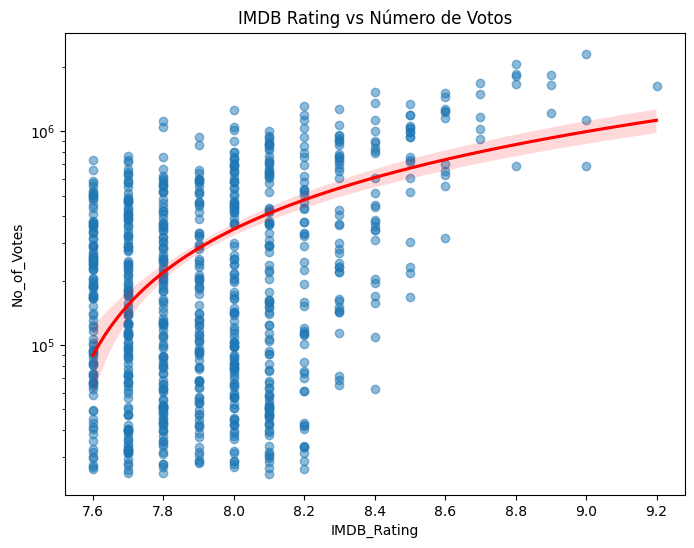

In [596]:
plt.figure(figsize=(8,6))
sns.regplot(x="IMDB_Rating", y="No_of_Votes", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("IMDB Rating vs Número de Votos")
plt.yscale("log")
plt.show()


- **Relação positiva não linear**: notas mais altas tendem a ter mais votos.
- No entanto, o padrão é enviesado, alguns filmes medianos têm muitos votos – casos claros de filmes famosos que não são, necessariamente, excelentes.
- Podemos perceber que, apesar de não serem equivalentes, a popularidade (No_of_votes) e a qualidade (IMDB_Rating) se relacionam.

---

#### 5. Meta_score x Gross
**Hipótese 5:** A nota da crítica especializada influencia a bilheteria?

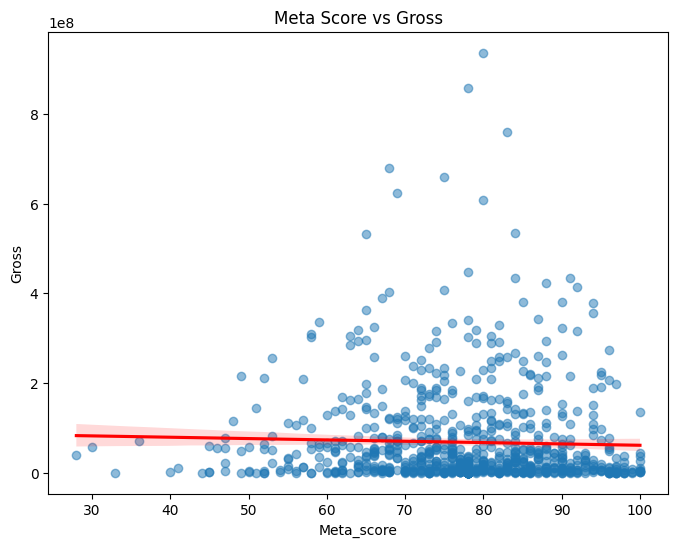

In [597]:
plt.figure(figsize=(8,6))
sns.regplot(x="Meta_score", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Meta Score vs Gross")
plt.show()


- Praticamente nenhuma relação, a linha de tendência é quase plana.
- Mostra que a crítica especializada (Meta_score) não impacta diretamente o faturamento.

Com isso, podemos perceber, também, que a bilheteria depende muito mais de popularidade (consequentemente, marketing) do que de crítica.

---

### Distribuições univariadas

#### Variáveis numéricas

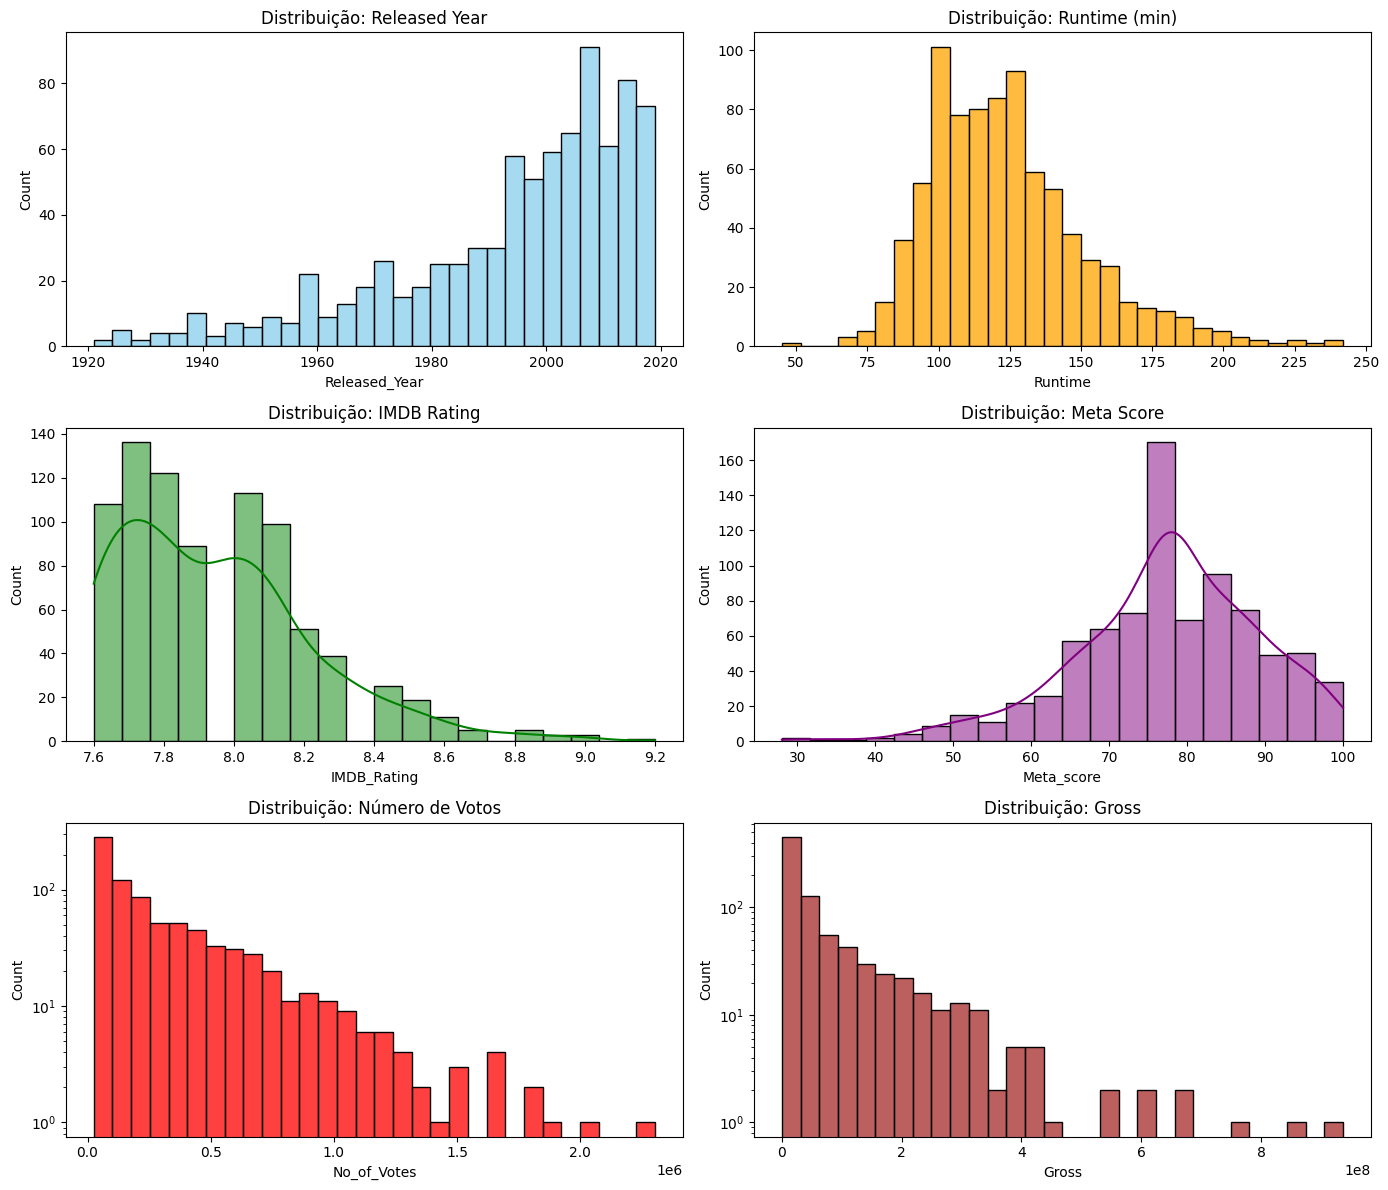

In [598]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Ano de lançamento
sns.histplot(df_cleaned["Released_Year"], bins=30, kde=False, ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Distribuição: Released Year")

# Tempo de duração
sns.histplot(df_cleaned["Runtime"], bins=30, kde=False, ax=axes[0,1], color="orange")
axes[0,1].set_title("Distribuição: Runtime (min)")

# Avaliação IMDB
sns.histplot(df_cleaned["IMDB_Rating"], bins=20, kde=True, ax=axes[1,0], color="green")
axes[1,0].set_title("Distribuição: IMDB Rating")

# Avaliação da Crítica
sns.histplot(df_cleaned["Meta_score"], bins=20, kde=True, ax=axes[1,1], color="purple")
axes[1,1].set_title("Distribuição: Meta Score")

# Número de votos
sns.histplot(df_cleaned["No_of_Votes"], bins=30, kde=False, ax=axes[2,0], color="red")
axes[2,0].set_title("Distribuição: Número de Votos")
axes[2,0].set_yscale("log")

# Faturamento da bilheteria
sns.histplot(df_cleaned["Gross"], bins=30, kde=False, ax=axes[2,1], color="brown")
axes[2,1].set_title("Distribuição: Gross")
axes[2,1].set_yscale("log")

plt.tight_layout()
plt.show()


- **Hipótese 6:** O dataset é enviesado para filmes recentes (2000-2020), o que pode distorcer análises históricas
> A maioria dos registros, de fato, se concentra nesse período.
- **Hipótese 7:** A maioria dos filmes tem duração próxima de 100-125 minutos.
> ``Runtime`` tem uma distribuição estável e centrada nesse intervalo, com raros casos extremos.
- **Hipótese 8:** Como a base seleciona apenas filmes bem avaliados (IMDb >= 7.6), prever ratings baixos pode ser inconsistente.
> A distribuição de ``IMDB_Rating`` é concentrada entre 7.6 e 8.1, com cauda longa até 9+.
- **Hipótese 9:** A crítica tende a avaliar de forma estável, sem extremos, concentrando notas em torno de 75-80.
> ``Meta_score`` é quase simétrico, com pico próximo à média (que, relembrando, é aproximadamente 78).
- **Hipótese 10:** Popularidade segue um padrão de long tail, porque enquanto poucos filmes acumulam milhões de votos, a maioria recebe pouco engajamento. 
>  ``No_of_votes``é altamente enviesada à direita.
-  **Hipótese 11:** O mercado de cinema é dominado por poucos blockbusters, enquanto a maioria dos filmes tem faturamento modesto.
> ``Gross`` também segue uma distribuição enviesada à direita.

---

#### Variáveis categóricas

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_21796\3445344087.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")


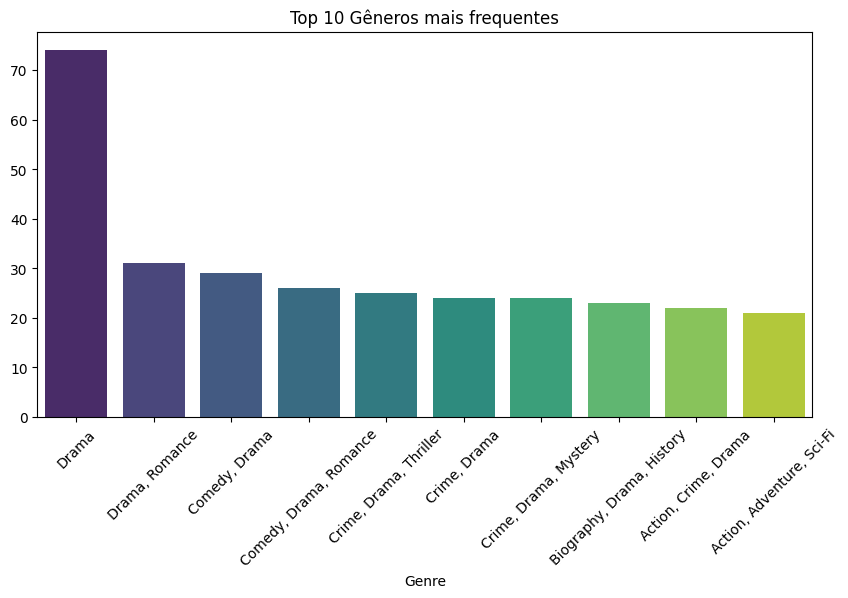

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_21796\3445344087.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Certificate", data=df_cleaned, order=df_cleaned["Certificate"].value_counts().index, palette="viridis")


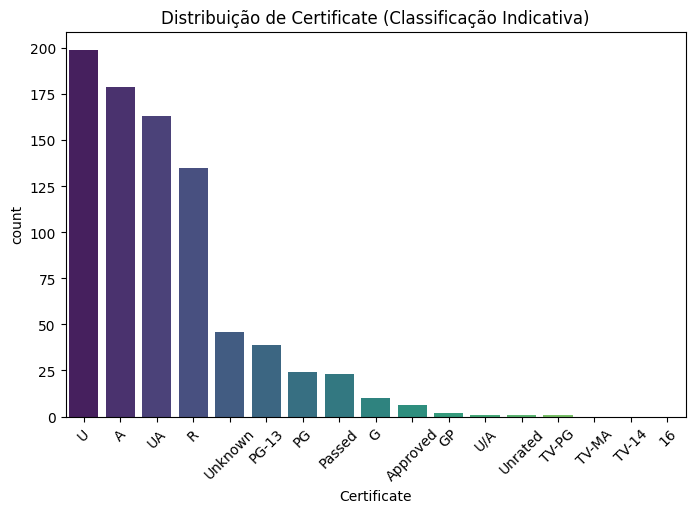

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_21796\3445344087.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.index, y=top_directors.values, palette="viridis")


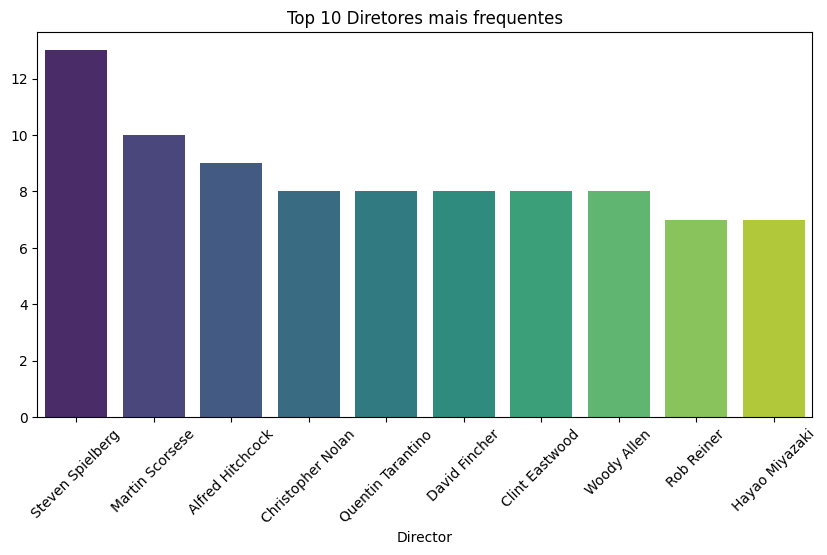

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_21796\3445344087.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_stars.index, y=top_stars.values, palette="viridis")


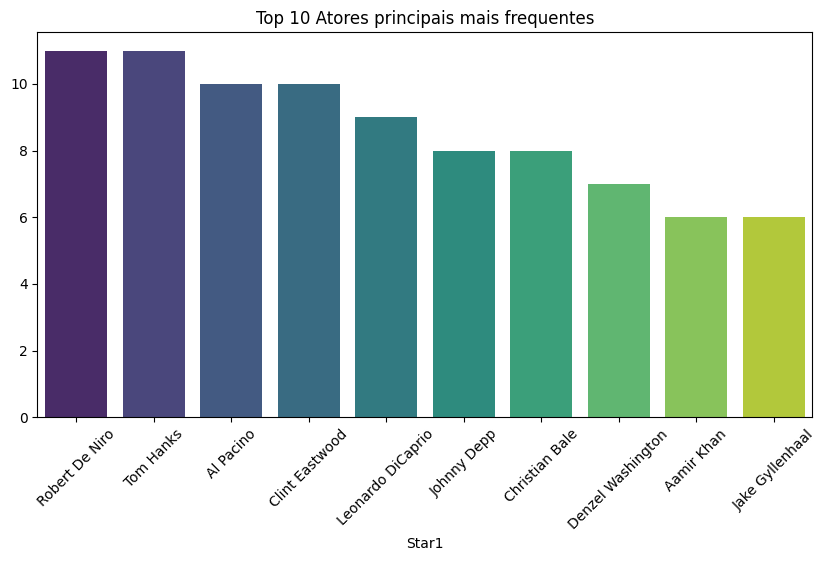

In [599]:
# Gênero
plt.figure(figsize=(10,5))
top_genres = df_cleaned["Genre"].value_counts().head(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Gêneros mais frequentes")
plt.show()

# Classificação indicativa
plt.figure(figsize=(8,5))
sns.countplot(x="Certificate", data=df_cleaned, order=df_cleaned["Certificate"].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribuição de Certificate (Classificação Indicativa)")
plt.show()

# Diretor
plt.figure(figsize=(10,5))
top_directors = df_cleaned["Director"].value_counts().head(10)
sns.barplot(x=top_directors.index, y=top_directors.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Diretores mais frequentes")
plt.show()

# Ator/atriz principal
plt.figure(figsize=(10,5))
top_stars = df_cleaned["Star1"].value_counts().head(10)
sns.barplot(x=top_stars.index, y=top_stars.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Atores principais mais frequentes")
plt.show()


##### Gênero
**Hipótese 12:** O dataset é enviesado para dramas, o que pode afetar previsões de outros gêneros menos representados.
- Drama é o que domina, seguido por combinações como Drama + Romance e Comedy + Drama.
- Gêneros mais "populares" como Action ou Sci-Fi também aparecem, mas com frequência bem menor.

---

##### Classificação indicativa
**Hipótese 13:** Filmes livres (U, A, UA) dominam, mas há desbalanceamento entre categorias, um forte indicador de comprometimento da análise preditiva.
- A maioria está classificada como U (Universal, livre para todos), seguido por A (Adultos) e UA (Acompanhado por adultos).
- Existe uma boa diversidade de classificações, mas muitos valores foram classificados como "Unknown", na limpeza dos dados.
- Existem categorias pouco representadas, como TV-14, GP, etc.

---

##### Diretores mais frequentes
**Hipótese 14:** O dataset privilegia diretores consagrados, refletindo uma curadoria de "filmes importantes", e não uma amostra aleatória.
- Steven Spielberg aparece como o diretor mais recorrente, com boa vantagem. 
- Outros nomes fortes como Scorsese, Hitchcock, Nola e Tarantino tambémn estão no top 10.

---

##### Atores principais
**Hipótese 15:** O dataset privilegia atores clássicos de Hollywood, sugerindo foco em prestígio mais do que diversidade.
- Robert De Niro e Tom Hanks lideram, seguidos por Al Pacino, Clint Eastwood e Leonardo DiCaprio.

---

### Relações entre variáveis
#### Gênero

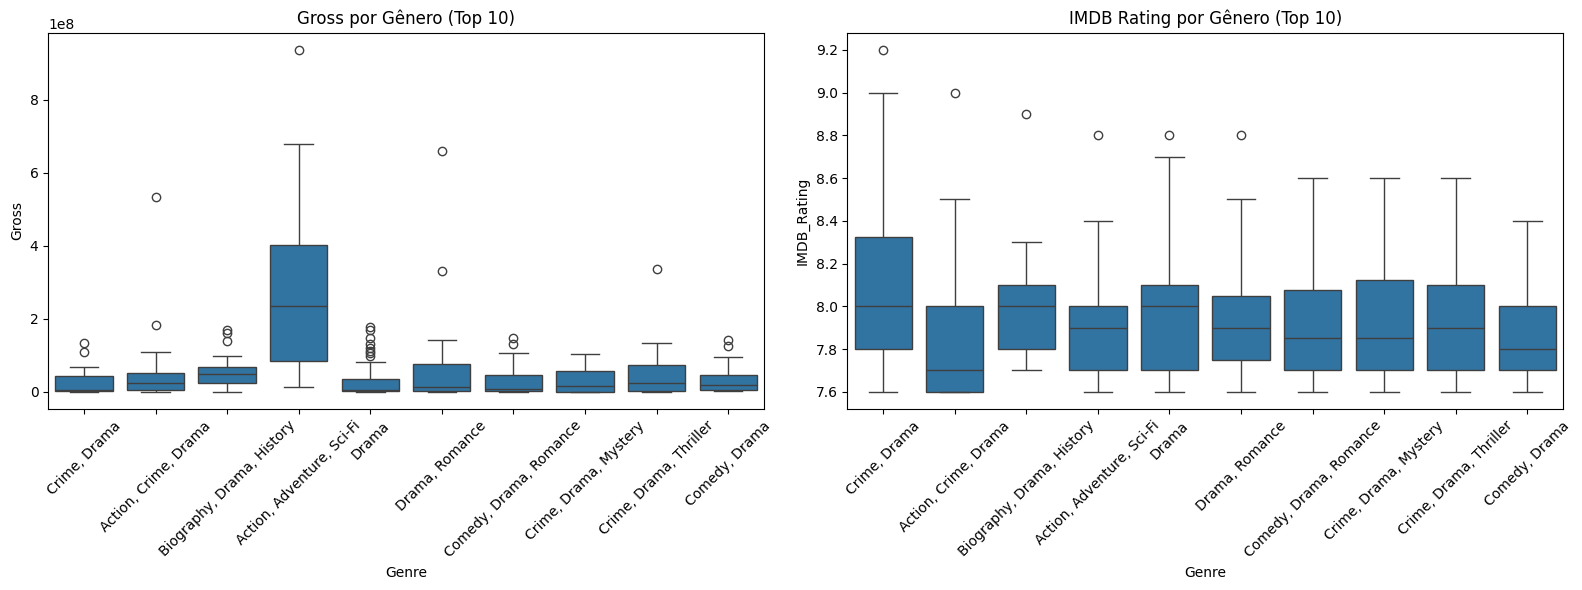

In [600]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Genre x Gross
top_genres = df_cleaned["Genre"].value_counts().head(10).index
sns.boxplot(x="Genre", y="Gross", data=df_cleaned[df_cleaned["Genre"].isin(top_genres)],
            ax=axes[0])
axes[0].set_title("Gross por Gênero (Top 10)")
axes[0].tick_params(axis="x", rotation=45)

# Genre x IMDB
sns.boxplot(x="Genre", y="IMDB_Rating", data=df_cleaned[df_cleaned["Genre"].isin(top_genres)],
            ax=axes[1])
axes[1].set_title("IMDB Rating por Gênero (Top 10)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

**Hipótese 16:** Alguns gêneros concentram blockbusters, enquanto outros permanecem com bilheterias medianas baixas.
> A maior variabilidade está em "Biography, Drama, History" e "Action, Adventure, Sci-Fi", gêneros que concentram os maiores outliers de bilheteria.
Apesar disso, a maioria dos gêneros apresenta medianas de Gross relativamente baixas, com grandes caudas influenciadas por poucos filmes de enorme sucesso.
Ou seja, o gênero por si só não garante arrecadação, mas alguns gêneros (ação/aventura/ficção científica) tendem a concentrar os maiores sucessos comerciais.

**Hipótese 17:** O gênero influencia pouco a avaliação crítica/popular, já que a mediana de IMDB_Rating é muito próxima entre todos os gêneros
> As medianas de nota são muito próximas entre si, geralmente entre 7.7 e 8.1, o que indica pouca variabilidade. "Crime, Drama" se destaca por ter a maior mediana de rating, além de uma dispersão relativamente alta. 

**Hipótese 18:** O gênero mais frequente (Drama) não é o mais lucrativo.
> Gêneros menos frequentes (ação, sci-fi, biografia histórica) conseguiram resultados financeiros muito maiores, mesmo aparecendo menos no dataset.

---

#### Diretor

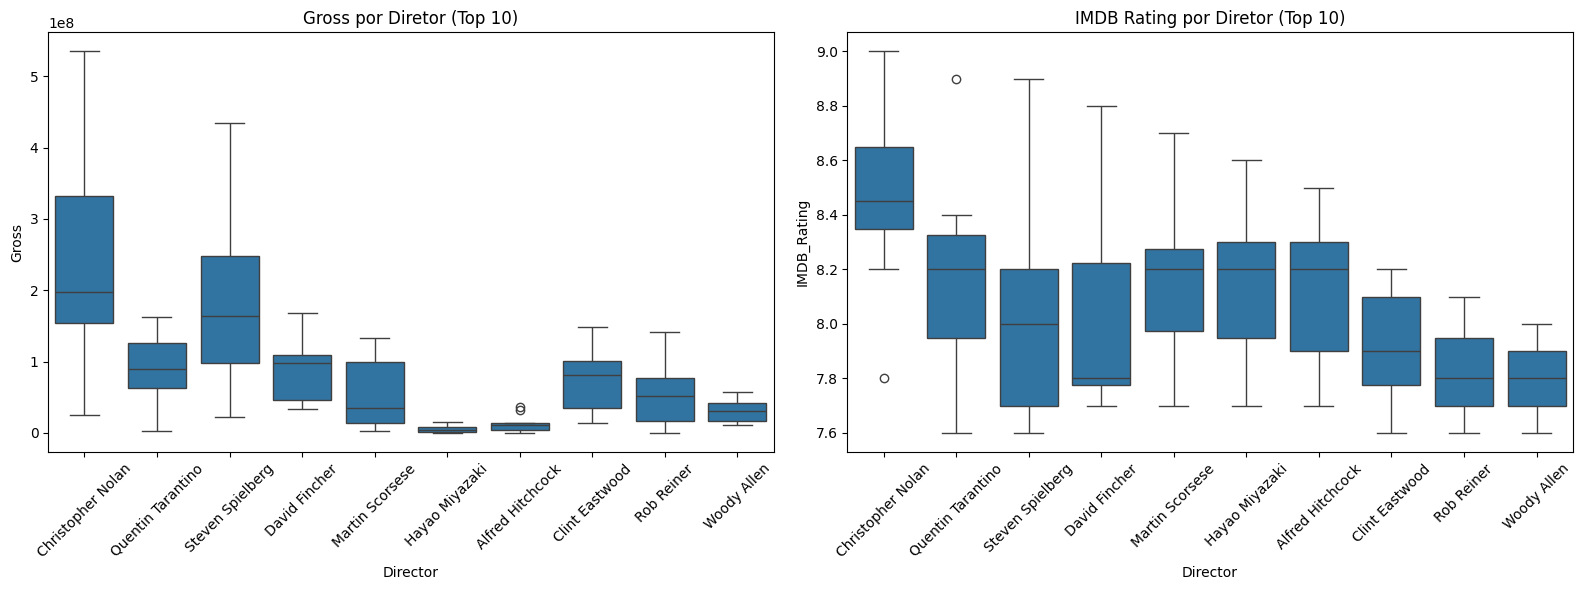

In [601]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

top_directors = df_cleaned["Director"].value_counts().head(10).index

# Director x Gross
sns.boxplot(x="Director", y="Gross", data=df_cleaned[df_cleaned["Director"].isin(top_directors)],
            ax=axes[0])
axes[0].set_title("Gross por Diretor (Top 10)")
axes[0].tick_params(axis="x", rotation=45)

# Director x IMDb_Rating
sns.boxplot(x="Director", y="IMDB_Rating", data=df_cleaned[df_cleaned["Director"].isin(top_directors)],
            ax=axes[1])
axes[1].set_title("IMDB Rating por Diretor (Top 10)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

**Hipótese 19:** Diretores consagrados diferem no desempenho financeiro.
> Christopher Nolan e Steven Spielberg se destacam com maiores medianas de bilheteria, ao mesmo tempo que possuem o maior número de outliers. São os diretores com filmes que mais geraram blockbusters.
Scorsese e David Fincher, apesar de estarem entre os mais frequentes, aparecem com medianas mais baixas em Gross.
E, por fim, Hayao Miyazki e Woody Allen aparecem no top 10 em frequência, mas seus filmes tem bilheterias bem menores.

**Hipótese 20:** A avaliação popular está mais associada a alguns diretores específicos.
> Sobre a avaliação do IMDb, o Nolan segue sendo o destaque, com mediana próxima a 8.5, e com outliers chegando a quase 9.0.
Apesar de terem menor dispersão, Scorsese, Hitchcock e Miyazaki têm medianas altas. Por fim, Woody Allen e Rob Reiner apresentam medianas mais baixas.

**Hipótese 21:** A frequência de diretores no dataset não está ligada ao desempenho financeiro nem crítico.
> Alguns diretores não têm a mesma performance, em termos de faturamento, mesmo sendo mais frequentes.
Nolan, mesmo sendo menos frequente do que Scorsese e Hitchcock, tem mais faturamento e melhor avaliação IMDb, o que mostra que a qualidade e o impacto comercial dos seus filmes compensa a menor quantidade.

---

#### Ator principal

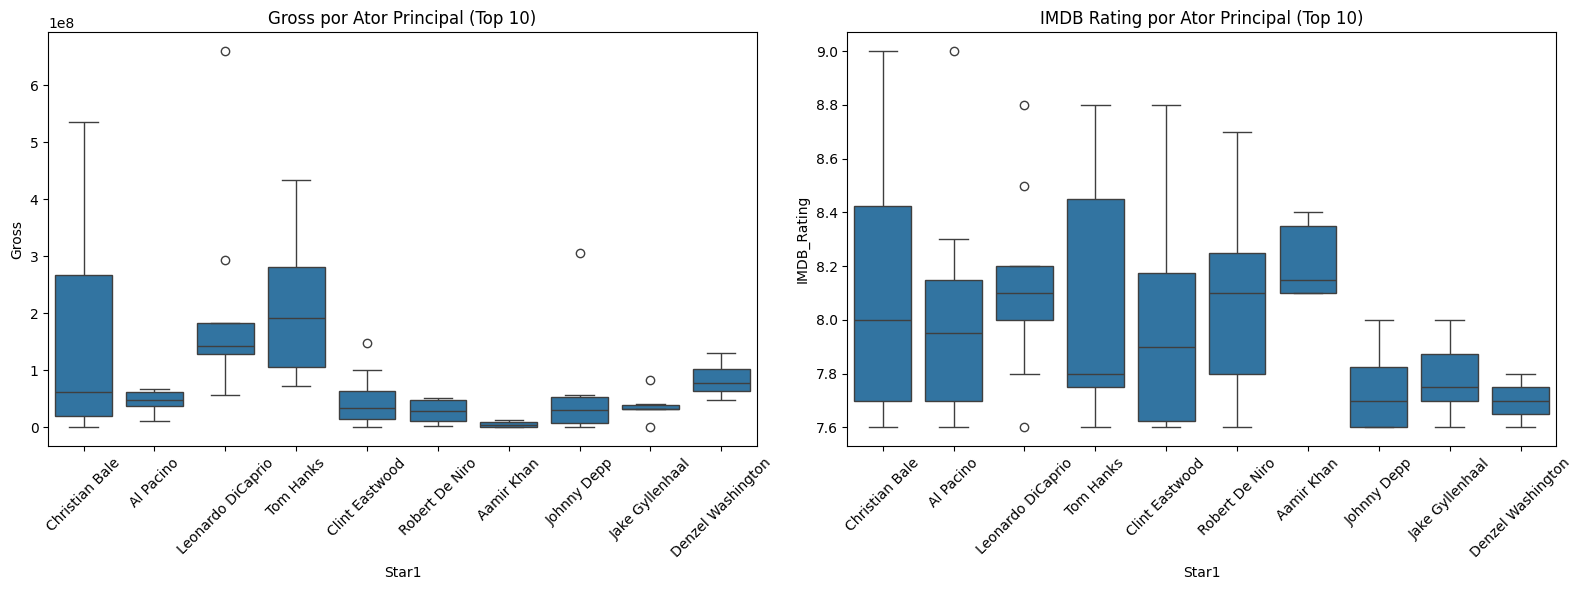

In [602]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

top_stars = df_cleaned["Star1"].value_counts().head(10).index

# Star1 x Gross
sns.boxplot(x="Star1", y="Gross", data=df_cleaned[df_cleaned["Star1"].isin(top_stars)],
            ax=axes[0])
axes[0].set_title("Gross por Ator Principal (Top 10)")
axes[0].tick_params(axis="x", rotation=45)

# Star1 x IMDb_Rating
sns.boxplot(x="Star1", y="IMDB_Rating", data=df_cleaned[df_cleaned["Star1"].isin(top_stars)],
            ax=axes[1])
axes[1].set_title("IMDB Rating por Ator Principal (Top 10)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


**Hipótese 22:** Atores de blockbusters concentram as maiores bilheterias, mesmo sem serem os mais frequentes.
> Em relação ao faturamento, DiCaprio e Hanks apresentam medianas altas de bilheteria, além de outliers que chegam a centenas de milhões, o que indica claramente os blockbusters em suas carreiras.
Já atores muito frequentes no dataset como Robert De Niro e Al Pacino apresentam medianas bem mais baixas em Gross, mostrando que a quantidade de filmes não significa bilheteria alta.

**Hipótese 23:** O desempenho em IMDB_Rating é relativamente estável entre atores, com algumas exceções.
> As notas são relativamente próximas, seguem a distribuição média da variável. Aamir Khan aparece com uma mediana alta de rating, embora sua frequência no dataset seja menor. Enquanto isso, DiCaprio, Hanks e Bale também têm distribuições amplas, com filmes tanto medianos quanto muito bem avaliados. 

**Hipótese 24:** A frequência de aparição no dataset não implica maior sucesso comercial.
> De Niro tem muitos filmes, mas baixa bilheteria mediana. Hanks, por outro lado, consegue aliar alta frequência com bom desempenho em Gross. Atores menos frequentes, como Leonardo DiCaprio e Christian Bale aparecem com maior impacto financeiro, mesmo com menos títulos no dataset.

---

### Correlações numéricas

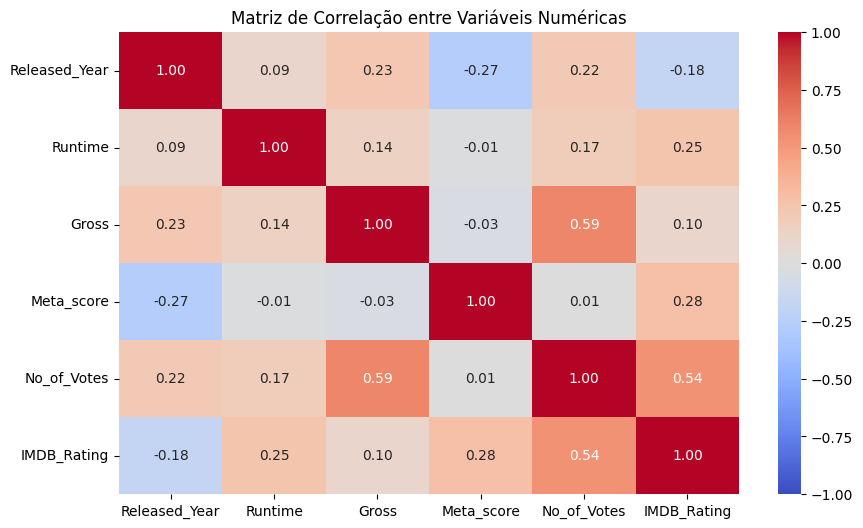

In [603]:
plt.figure(figsize=(10,6))

corr = df_cleaned[["Released_Year", "Runtime", "Gross",
                   "Meta_score", "No_of_Votes", "IMDB_Rating"]].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

**Hipótese 25:** Filmes mais populares tendem a ter notas mais altas.
> Correlação positiva moderada entre ``No_of_votes`` (0.54) e `IMDB_Rating`

**Hipótese 26:** Filmes mais longos recebem avaliações ligeiramente melhores.
> `Runtime` tem correlação positiva baixa (~0.25) com `IMDB_Rating`.

**Hipótese 27:** A nota da crítica especializada (`Meta_score`) está alinhada à percepção do público.
> Correlação positiva baixa (~0.28) entre `Meta_score` e `IMDB_Rating`.

**Hipótese 28:** Sucesso de bilheteria não garante boas avaliações.
> Correlação muito baixa (~0.10) entre `Gross` e `IMDB_Rating`.

**Hipótese 29:** Filmes mais recentes tendem a ter notas ligeiramente mais baixas.
> Correlação negativa fraca (~-0.18) entre `Released_Year` e `IMDB_Rating`.